# Hedging Analysis using Jupyter Notebook

You are asked to maintain a pair trade of TQQQ long and QLD short so that over a period of 3 months the net profit is zero. You are constrained to the following:

Initial TQQQ long position has $1 million market value.
You can only rebalance the pair trade by trading QLD. That is, leave the TQQQ long position intact.
For rebalancing trade, you can only perform it at opening and/or closing auctions. That is, you can trade at most twice a day, and the price you get is either the open price or close price.
 
Present a quantitative analysis of different rebalancing strategies and make a recommendation.

You can get the open and close price data from Yahoo Finance.

In [222]:
## Import libraries
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import dateutil.relativedelta as relativedelta

tickets = ["TQQQ", "QLD"]

ticketsYF = yf.Tickers(tickets)

start_date = '2022-11-22'
rd = relativedelta.relativedelta(months = 3)
end_date = (datetime.strptime(start_date, "%Y-%m-%d") + rd).strftime("%Y-%m-%d")

dfRaw = ticketsYF.history(start=start_date, end=end_date)

[*********************100%***********************]  2 of 2 completed


In [223]:
dfRaw = dfRaw[["Open", "Close"]].unstack().to_frame()
dfRaw = dfRaw.reset_index().rename(columns = {0: "price", "level_0": "type", "level_1": "ticket", "Date": "date"})
dfRaw

,type,ticket,date,price
0,Open,QLD,2022-11-22,39.832974
1,Open,QLD,2022-11-23,40.760250
2,Open,QLD,2022-11-25,41.089283
3,Open,QLD,2022-11-28,40.431217
4,Open,QLD,2022-11-29,39.842945
...,...,...,...,...
239,Close,TQQQ,2023-02-14,25.490000
240,Close,TQQQ,2023-02-15,26.059999
241,Close,TQQQ,2023-02-16,24.570000
242,Close,TQQQ,2023-02-17,24.040001


In [224]:
dateHoursList = []
for row in range(len(dfRaw)):
    if dfRaw.loc[row, "type"] == "Open":
        dateHoursList.append(dfRaw.loc[row, "date"] + relativedelta.relativedelta(hours = 8))
    if dfRaw.loc[row, "type"] == "Close":
        dateHoursList.append(dfRaw.loc[row, "date"] + relativedelta.relativedelta(hours = 15))    

dfRaw["date_hour"] = dateHoursList

dfClean = dfRaw.set_index(["date_hour"])[["ticket", "price", "type"]]
dfClean

,ticket,price,type
date_hour,,,
2022-11-22 08:00:00,QLD,39.832974,Open
2022-11-23 08:00:00,QLD,40.760250,Open
2022-11-25 08:00:00,QLD,41.089283,Open
2022-11-28 08:00:00,QLD,40.431217,Open
2022-11-29 08:00:00,QLD,39.842945,Open
...,...,...,...
2023-02-14 15:00:00,TQQQ,25.490000,Close
2023-02-15 15:00:00,TQQQ,26.059999,Close
2023-02-16 15:00:00,TQQQ,24.570000,Close


In [225]:
dfCleanPivot = dfClean.pivot_table(index = "date_hour", columns = "ticket", values = "price")
dfCleanPivot

ticket,QLD,TQQQ
date_hour,,
2022-11-22 08:00:00,39.832974,21.219866
2022-11-22 15:00:00,40.760250,21.956045
2022-11-23 08:00:00,40.760250,21.936147
2022-11-23 15:00:00,41.567875,22.612637
2022-11-25 08:00:00,41.089283,22.224652
...,...,...
2023-02-16 15:00:00,44.669998,24.570000
2023-02-17 08:00:00,44.040001,24.030001
2023-02-17 15:00:00,44.029999,24.040001


<Axes: title={'center': 'Price time series [$]'}, xlabel='date_hour'>

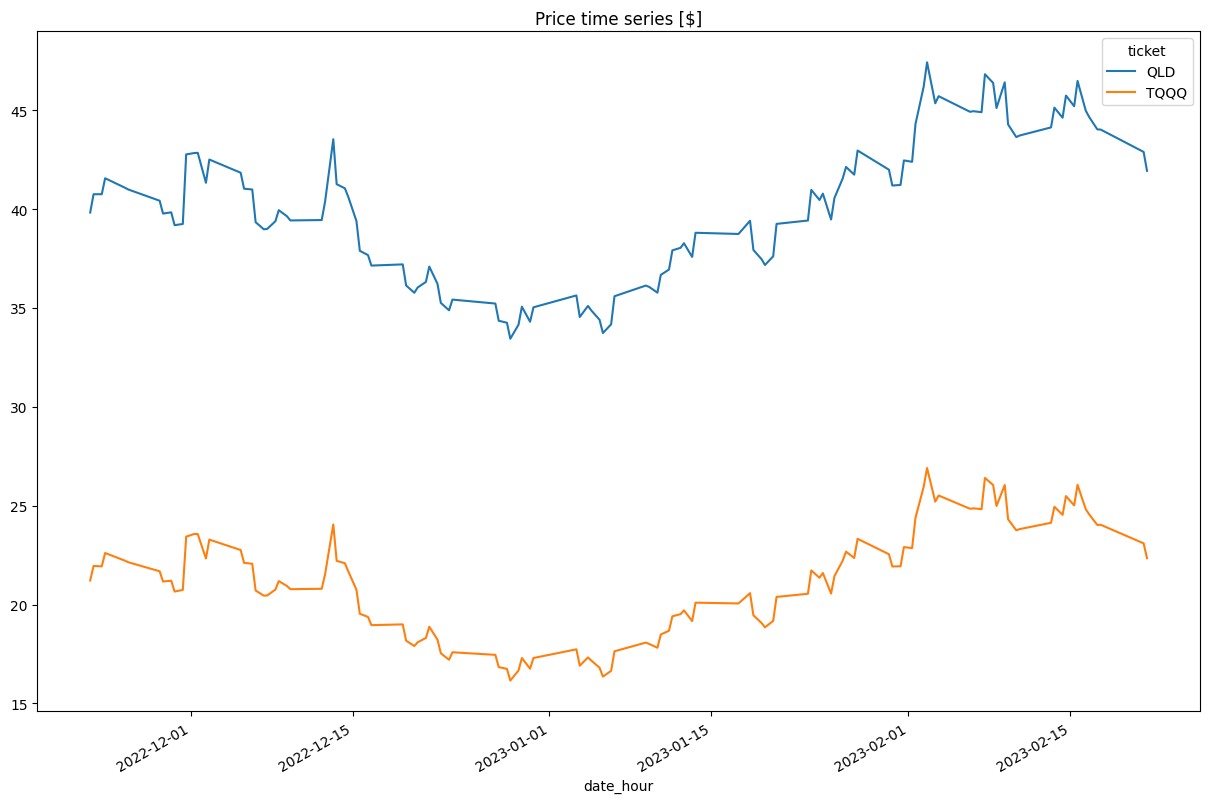

In [226]:
dfCleanPivot.plot(figsize = (15, 10), title = "Price time series [$]")

In [227]:
## Lets calculate log returns

dfCleanTemp = dfClean.loc[dfClean["type"] == "Close"].pivot_table(index = "date_hour", columns = "ticket", values = "price")
dfReturns = (np.log(dfCleanTemp) - np.log(dfCleanTemp.shift(1))).dropna()
dfReturns.head()

ticket,QLD,TQQQ
date_hour,,
2022-11-23 15:00:00,0.019620,0.029466
2022-11-25 15:00:00,-0.013767,-0.020894
2022-11-28 15:00:00,-0.030118,-0.045024
2022-11-29 15:00:00,-0.014897,-0.024258
2022-11-30 15:00:00,0.087393,0.126041


<Axes: title={'center': 'Log. return time series [%]'}, xlabel='date_hour'>

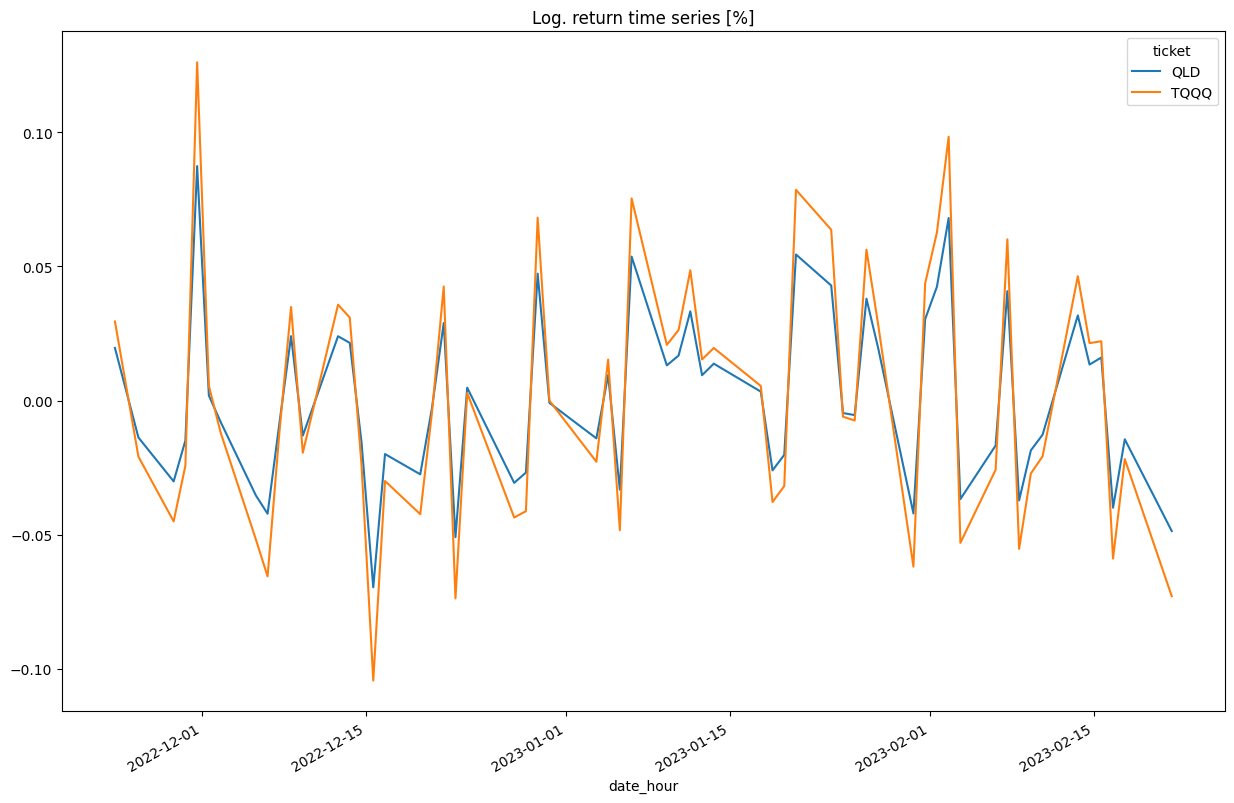

In [228]:
dfReturns.plot(figsize = (15,10), title = "Log. return time series [%]")

In [267]:
dfReturns.to_csv("rets.csv")

## First strategy: Buy and hold

In this case, based on the idea that TQQQ seeks to return X3 times the underlyin asset (Nasdaq-100 idex) and QLD does the same but X2 times, we will have this:

- $E[R_{TQQQ}] = E[3*R_{Nasdaq100}] = 3 E[R_{Nasdaq100}] = 3 \overline{R_{Nasdaq100}}$
- $E[R_{QLD}] = E[2*R_{Nasdaq100}] = 2 E[R_{Nasdaq100}] = 2 \overline{R_{Nasdaq100}}$

At the end, we got a portfolio:

- $E[R_{port}] = E[w_{TQQQ} * R_{TQQQ} + w_{QLD} * R_{QLD}] = w_{TQQQ} * 3 \overline{R_{Nasdaq100}} + w_{QLD} * 2 \overline{R_{Nasdaq100}} = 0$

So, in this case we got a solutions assuming no leverage ($w_{TQQQ} + w_{QLD} = 100%$):

- $w_{TQQQ} = -200\%$ and $w_{QLD} = 300\%$ but we already have a long position on TQQD, so the final weights are $w_{TQQQ} = 200\%$ and $w_{QLD} = -300\%$.

Based on previous weights be got:
- $\text{initValTQQQ} = \$1.000.000$
- $\text{initValQLD} = -\$1.500.000$ 

<Axes: title={'center': 'Cummulative return time series [%]'}, xlabel='date_hour'>

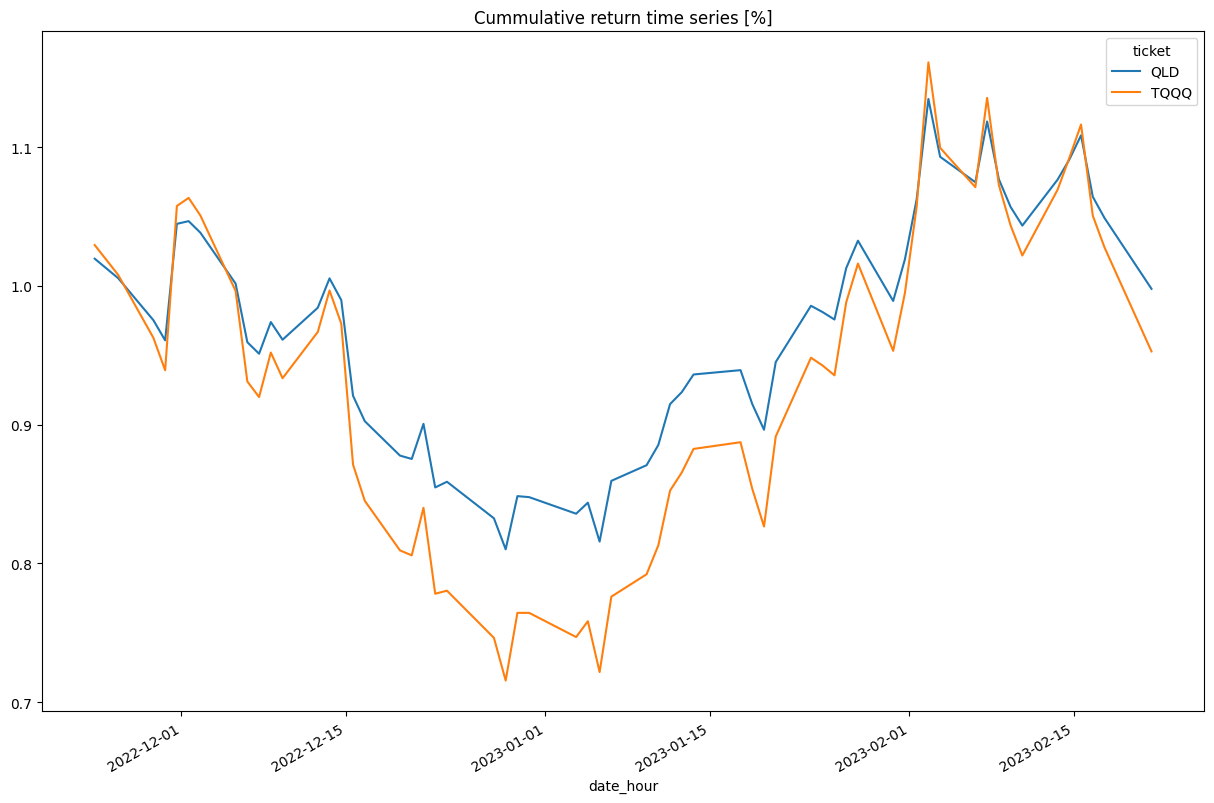

In [270]:
## Initial Investment per asset

initValTQQQ = 1000000
initValQLD = -1500000

dfCompRet = (dfReturns + 1).cumprod()
dfCompRet.plot(figsize = (15, 10), title = "Cummulative return time series [%]")

<Axes: title={'center': 'Value time series [$]'}, xlabel='date_hour'>

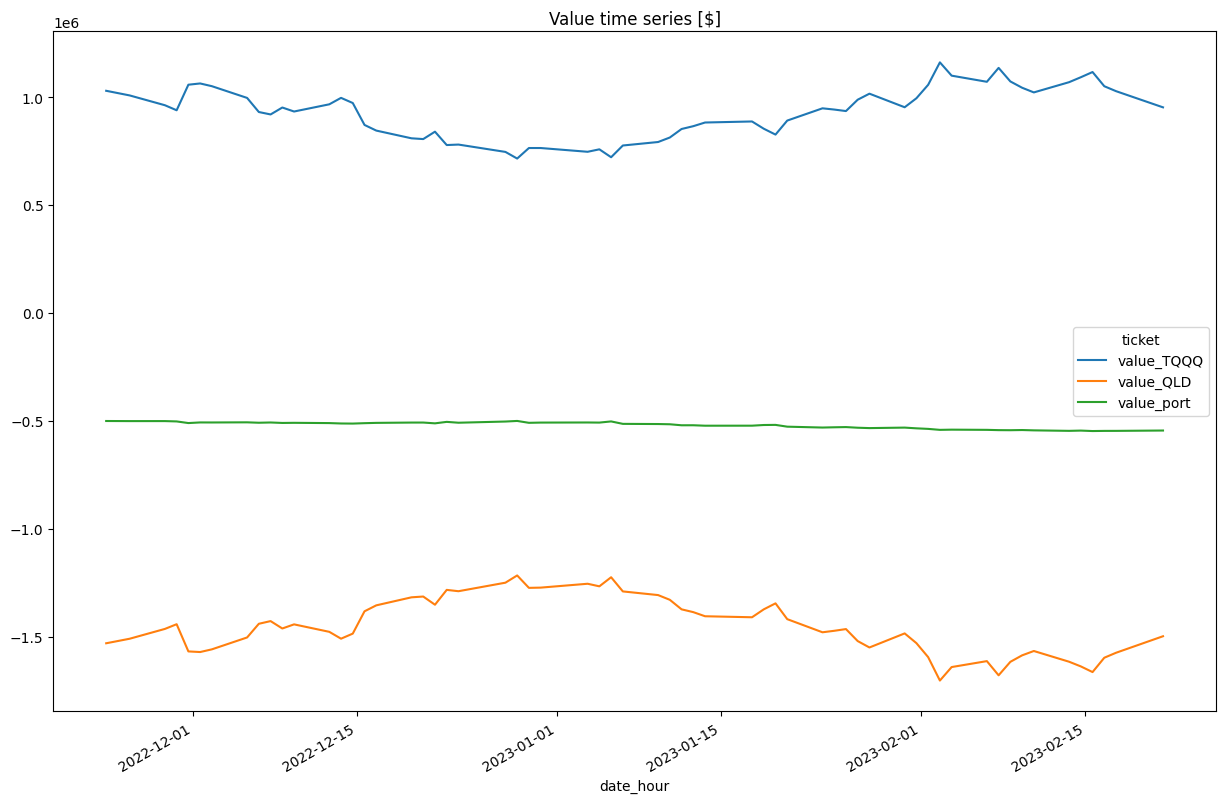

In [271]:
# Value of investment in time
dfValue = dfCompRet.copy()
dfValue["value_TQQQ"] = initValTQQQ * dfCompRet["TQQQ"]
dfValue["value_QLD"] = initValQLD * dfCompRet["QLD"]
dfValue["value_port"] = dfValue["value_TQQQ"] + dfValue["value_QLD"]

dfValue[["value_TQQQ", "value_QLD", "value_port"]].plot(figsize = (15, 10), title = "Value time series [$]")

In [264]:
dfWeights = pd.DataFrame(index = dfValue.index)
dfWeights["QLD"] = dfValue["value_QLD"] / np.abs(dfValue["value_port"])
dfWeights["TQQQ"] = dfValue["value_TQQQ"] / np.abs(dfValue["value_port"])
dfWeights.head()

,QLD,TQQQ
date_hour,,
2022-11-23 15:00:00,-3.059081,2.059081
2022-11-25 15:00:00,-3.014226,2.014226
2022-11-28 15:00:00,-2.923721,1.923721
2022-11-29 15:00:00,-2.871236,1.871236
2022-11-30 15:00:00,-3.075798,2.075798


<Axes: title={'center': 'Performance attribution - Cummulative return [%]'}, xlabel='date_hour'>

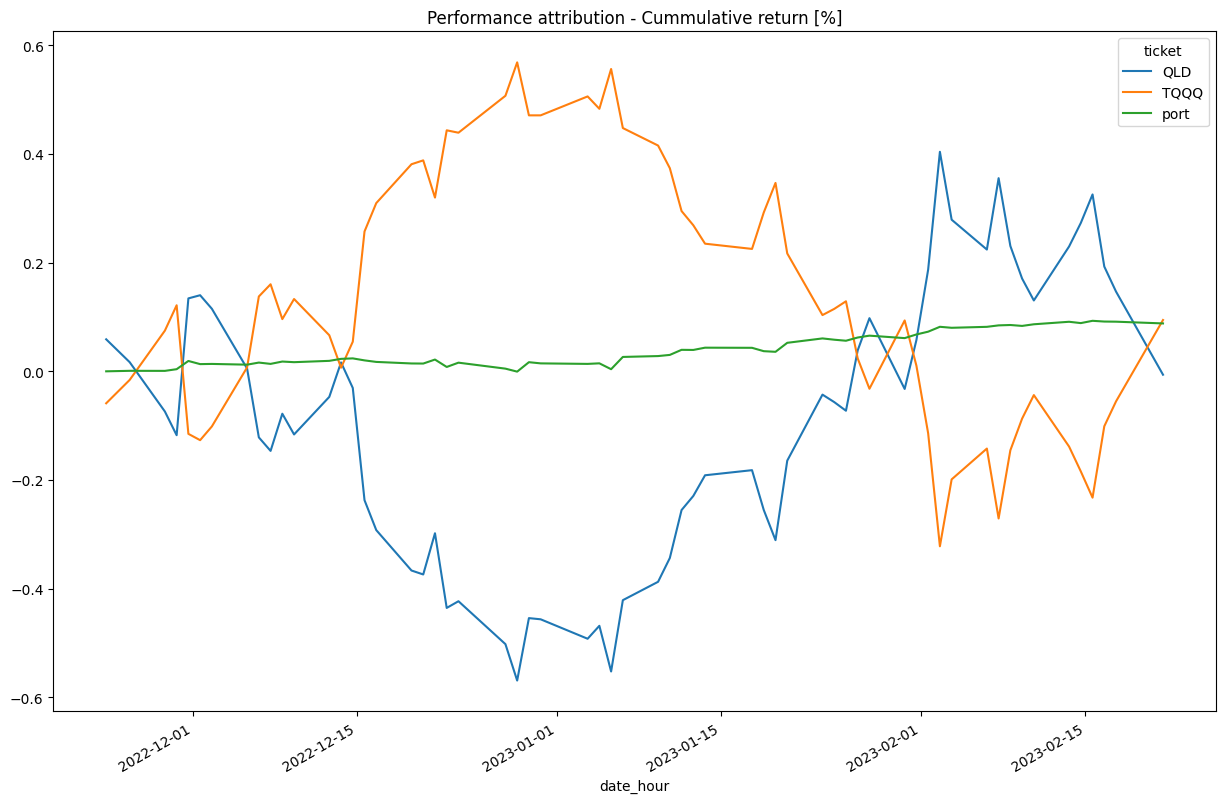

In [275]:
initialWeights = [initValQLD / (initValQLD + initValTQQQ), initValTQQQ / (initValQLD + initValTQQQ)]

dfCompRetPort = dfCompRet.copy() - 1
dfCompRetPort["QLD"] = dfCompRetPort["QLD"] * initialWeights[0]
dfCompRetPort["TQQQ"] = dfCompRetPort["TQQQ"] * initialWeights[1]
dfCompRetPort["port"] = dfCompRetPort["QLD"] + dfCompRetPort["TQQQ"]

dfCompRetPort.plot(figsize = (15, 10), title = "Performance attribution - Cummulative return [%]")

In [276]:
dfCompRetPort.tail()

ticket,QLD,TQQQ,port
date_hour,,,
2023-02-14 15:00:00,0.273079,-0.184362,0.088716
2023-02-15 15:00:00,0.325597,-0.232670,0.092927
2023-02-16 15:00:00,0.192789,-0.101221,0.091568
2023-02-17 15:00:00,0.146714,-0.055400,0.091314
2023-02-21 15:00:00,-0.006315,0.094424,0.088110


With the "buy-and-hold" strategy, we obtain 8.81% return. Despite the fact we assume that both assets track the same underlying when we calculate a rolling window correlation we see that it is not always -1, and the same 

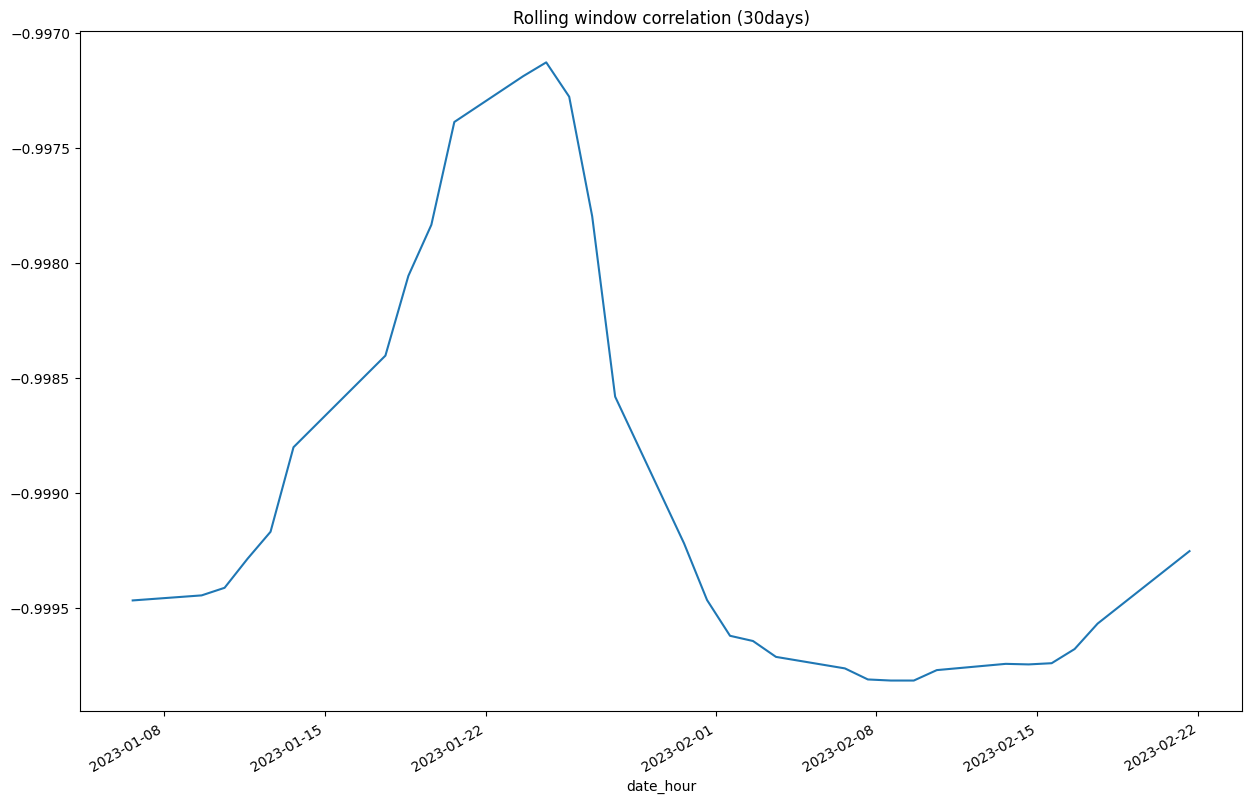

In [233]:
ax = dfCompRetPort["TQQQ"].rolling(30).corr(dfCompRetPort["QLD"]).plot(figsize = (15, 10), title = "Rolling window correlation (30days)")

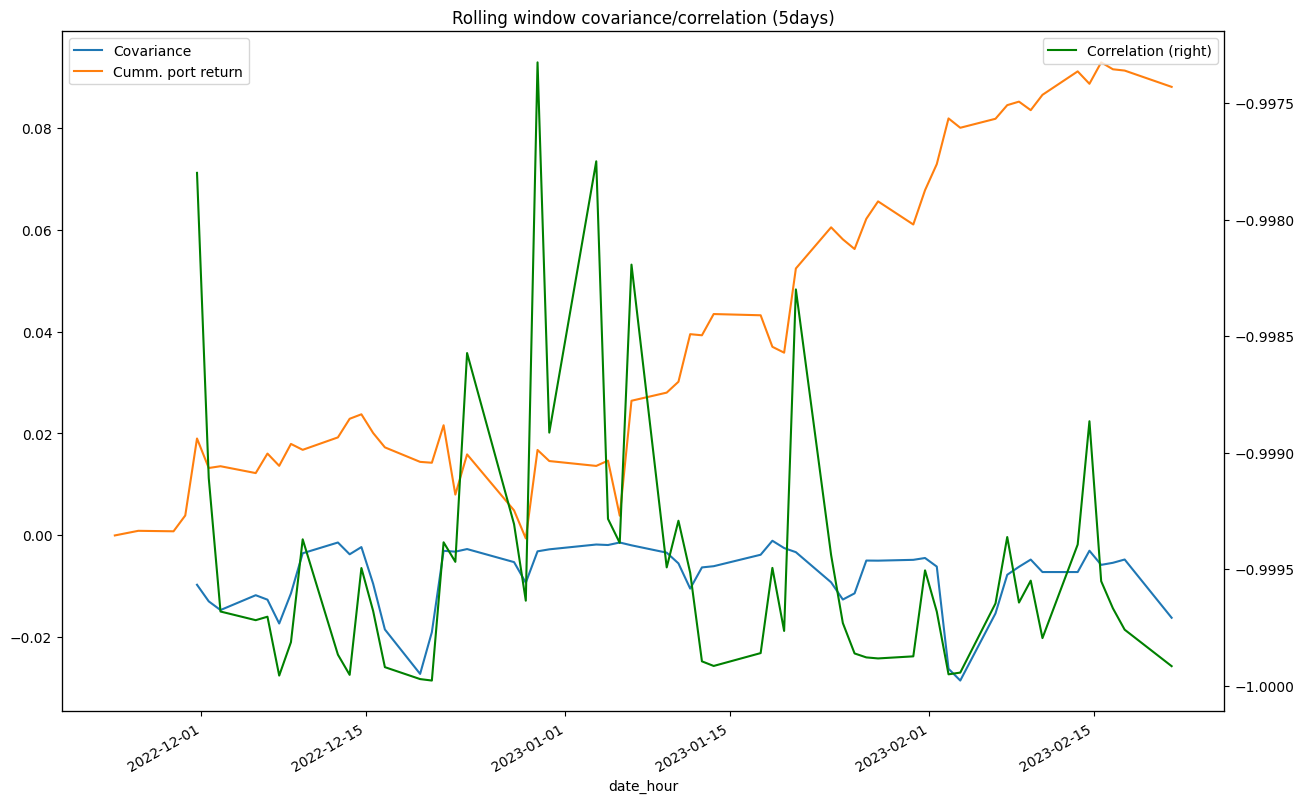

In [250]:
ax = dfCompRetPort["TQQQ"].rolling(5).cov(dfCompRetPort["QLD"]).plot(figsize = (15, 10), title = "Rolling window covariance/correlation (5days)", label = "Covariance")
ax = dfCompRetPort["port"].plot(figsize = (15, 10), label = "Cumm. port return")
ax2 = ax.twinx()
ax2 = dfCompRetPort["TQQQ"].rolling(5).corr(dfCompRetPort["QLD"]).plot(figsize = (15, 10),secondary_y=True, label = "Correlation", color = "green")
ax.legend()
ax2.legend()

<Axes: xlabel='date_hour'>

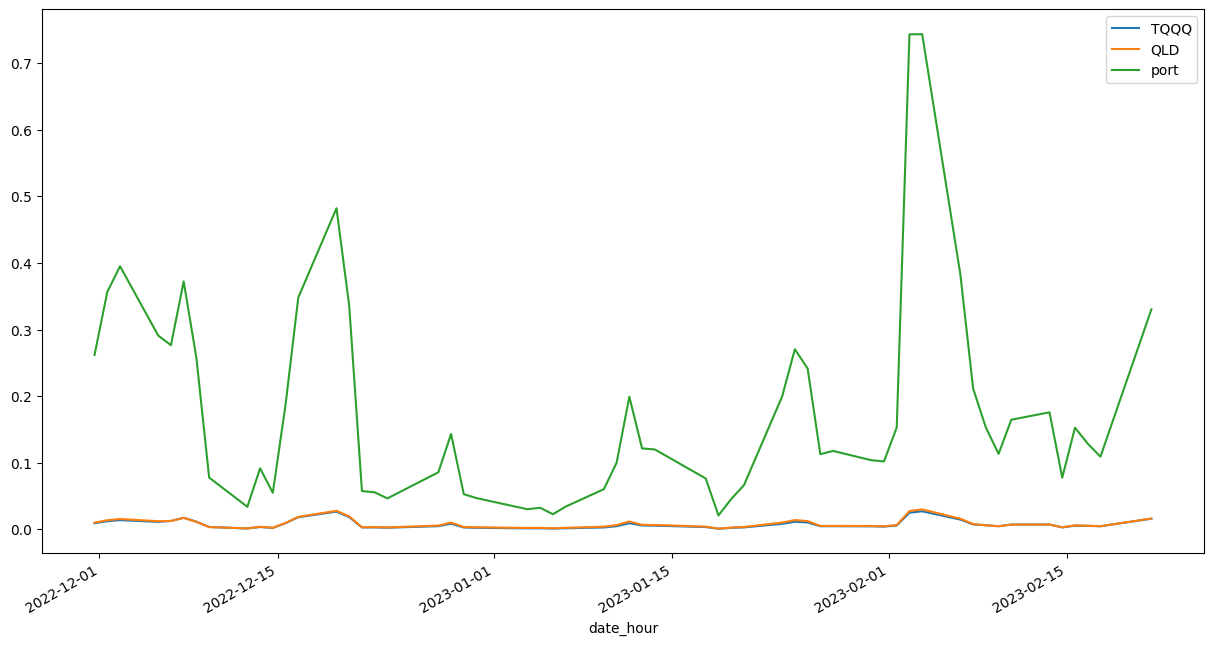

In [277]:
dfVariance = pd.DataFrame(index = dfCompRetPort.index)
dfVariance["TQQQ"] = (dfCompRetPort["TQQQ"].rolling(5).std())**2
dfVariance["QLD"] = (dfCompRetPort["QLD"].rolling(5).std())**2
dfVariance["port"] = (dfWeights["TQQQ"]**2) * dfVariance["TQQQ"] + (dfWeights["QLD"]**2) * dfVariance["QLD"] + 2 * dfWeights["TQQQ"] * dfWeights["QLD"] * (dfCompRetPort["TQQQ"].rolling(5).cov(dfCompRetPort["QLD"]))
dfVariance.plot(figsize = (15,8))

In [236]:
import pandas as pd
import numpy as np
import yfinance as yf

# Define the TQQQ and QLD tickers
tqqq_ticker = 'TQQQ'
qld_ticker = 'QLD'

# Set the initial TQQQ position value
tqqq_pos_value = 1000000

# Set the target volatility level
target_vol = 0.2

# Set the historical volatility window size
vol_window = 30

# Get the historical price data for TQQQ and QLD
prices = yf.download([tqqq_ticker, qld_ticker], start='2021-05-01')

# Calculate the daily returns for TQQQ and QLD
returns = np.log(prices/prices.shift(1))

# Calculate the daily volatility for QLD over the historical window
vol = returns["Close"][qld_ticker].rolling(window=vol_window).std()

# Initialize the position size for QLD
qld_pos_size = (tqqq_pos_value * target_vol) / vol.iloc[-1]

# Define a function to calculate the position size adjustment
def calc_pos_adjustment(tqqq_pos_value, qld_pos_size, target_vol, returns, vol):
    # Calculate the current volatility for TQQQ
    cur_vol = returns[tqqq_ticker].rolling(window=vol_window).std().iloc[-1]
    
    # Calculate the target position size for QLD
    target_pos_size = (tqqq_pos_value * target_vol) / cur_vol
    
    # Calculate the required adjustment in position size
    pos_adjustment = target_pos_size - qld_pos_size
    
    return pos_adjustment

# Simulate the rebalancing process over a historical period
for date, row in prices.iterrows():
    # Calculate the position adjustment
    pos_adjustment = calc_pos_adjustment(tqqq_pos_value, qld_pos_size, target_vol, returns.loc[:date], vol.loc[:date])
    
    # Place a sell order for QLD if the position size needs to be reduced
    if pos_adjustment < 0:
        qld_sell_size = -int(pos_adjustment)
        print(f"Selling {qld_sell_size} shares of {qld_ticker} at opening auction on {date}")
        # Place sell order for qld_sell_size shares at opening auction
        
    # Place a buy order for QLD if the position size needs to be increased
    elif pos_adjustment > 0:
        qld_buy_size = int(pos_adjustment)
        print(f"Buying {qld_buy_size} shares of {qld_ticker} at closing auction on {date}")
        # Place buy order for qld_buy_size shares at closing auction
    
    # Update the position size for QLD
    qld_pos_size += pos_adjustment
    
    # Update the TQQQ position value based on the daily return
    tqqq_pos_value *= np.exp(returns.loc[date, tqqq_ticker])
    
# Calculate the final net profit
final_value = tqqq_pos_value + qld_pos_size * prices.loc[prices.index[-1], qld_ticker]
net_profit = final_value - 1000000
print(f"Net Profit: ${net_profit:.2f}")


[*********************100%***********************]  2 of 2 completed


KeyError: 'TQQQ'